In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

def add_to_path(dir_path):
    if dir_path not in sys.path:
        sys.path.insert(0, dir_path)
        
add_to_path('src')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as plt

from modules import FG

In [4]:
MIN_YX, MAX_YX = -0.5, 1.5
MIN_HW, MAX_HW = 0.0, 1.0
ANCHORBOX_SHAPE = (48, 48)
OBJECT_SHAPE = (28, 28)

In [5]:
def sample_gaussean(mean, loc):
    dist = torch.distributions.normal.Normal(mean, loc)
    return dist.rsample()

def sample_bernoulli(p_logits, hard=True, clamp=False, temperature=1):
    dist = torch.distributions.RelaxedBernoulli(temperature=1, logits=p_logits)
    obj_prob = dist.rsample(p_logits.size()).to(device=p_logits.device)
    if hard:
        obj_prob_hard = (obj_prob >= 0.5).to(dtype=torch.float)
        return (obj_prob_hard - obj_prob).detach() + obj_prob, obj_prob
    else:
        return obj_prob, obj_prob

In [6]:
def sample_obj_pres(p_logits, st=True, clamp=False, eps=1e-20):
    if clamp:
        p_logits = torch.clamp(p_logits, -10., 10.)
    
    u = torch.rand(p_logits.size())
    noise = torch.log(u + eps) - torch.log(1.0 - u + eps)
    obj_pre_sigmoid = (p_logits + noise)
    obj_prob = torch.sigmoid(obj_pre_sigmoid)

    if st:
        obj_prob_hard = (obj_prob >= 0.5).to(p_logits.dtype)
        return (obj_prob_hard - obj_prob).detach() + obj_prob, obj_prob
    else:
        return obj_prob, obj_prob

In [74]:
class ImgEncoder(nn.Module):
    def __init__(self, num_channels=[3, 64, 64, 64, 64], out_proj_dim=64):
        super().__init__()
        
        self.num_channels = num_channels
        self.elu = nn.ELU()
        
        self.conv_layers = []
        for i in range(len(self.num_channels) - 1):
            self.conv_layers.append(nn.Sequential(
                nn.Conv2d(
                    in_channels=self.num_channels[i],
                    out_channels=self.num_channels[i+1],
                    kernel_size=(3,3),
                    stride=2,
                ),
                nn.BatchNorm2d(num_features=self.num_channels[i+1]),
                self.elu,
            ))
        self.conv_layers = nn.Sequential(*self.conv_layers)
        self.out_proj = nn.Sequential(
            nn.Conv2d(
                in_channels=self.num_channels[-1],
                out_channels=out_proj_dim,
                kernel_size=(1,1),
            ),
            # nn.Linear(in_features=self.num_channels[-1], out_features=out_proj_dim),
            self.elu,
        )
        
    def forward(self, x):
        # return self.out_proj(self.conv_layers(x).permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        return self.out_proj(self.conv_layers(x))
        
fg_enc = ImgEncoder()
# print(fg_enc)
fg_enc(torch.randn(1, 3, 64, 64)).size()

torch.Size([1, 64, 3, 3])

In [6]:
class FG(nn.Module):
    def __init__(self,
                 z_pres_dim=1,
                 z_depth_dim=1,
                 z_scale_dim=2,
                 z_shift_dim=2,
                 z_what_dim=32,
                 in_channels=64,
                ):
        super().__init__()
        
        self.z_pres_dim = z_pres_dim
        self.z_depth_dim = z_depth_dim
        self.z_scale_dim = z_scale_dim
        self.z_shift_dim = z_shift_dim
        
        self.z_dim = self.z_pres_dim + self.z_depth_dim * 2 + self.z_scale_dim * 2 + self.z_shift_dim * 2
        self.znet = nn.Conv2d(
            in_channels=in_channels,
            out_channels=self.z_dim,
            kernel_size=(1,1),
        )
        self.encoder = ImgEncoder()
        
    def forward(self, img):
        bsz, num_channels, h, w = img.size()
        
        img_feats = self.encoder(img)
        Z = self.znet(img_feats).permute(0, 2, 3, 1)
        
        pres_p, depth_mean, depth_log_std, scale_mean, scale_log_std, center_shift_mean, center_shift_log_std = Z.split([self.z_pres_dim, *(self.z_depth_dim,) * 2, *(self.z_scale_dim,) * 2, *(self.z_shift_dim,) * 2], dim=-1)
        
        obj_pres, obj_pres_prob = sample_obj_pres(pres_p, st=True)
        
        
        return Z
      
C, H, W = (3, 320, 480)
GLIMPSE_SHAPE = (16, 16)
fg = FG()
# img = torch.randn(1, C, H, W)
img = Image.open('/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/images/val/CLEVR_val_000000.png')
img = img.convert('RGB')
x = T.functional.to_tensor(img).unsqueeze(0)
Z = fg(x)
print(Z.size())
pres_p, depth_mean, depth_log_std, scale_mean, scale_log_std, center_shift_mean, center_shift_log_std = Z.split([1, 1, 1, 2, 2, 2, 2], dim=-1)

torch.Size([1, 19, 29, 11])


In [14]:
fg = FG()
img = Image.open('/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/images/val/CLEVR_val_000000.png')
img = img.convert('RGB')
x = T.functional.to_tensor(img).unsqueeze(0)
xs = fg(x)

19 29 torch.Size([1, 64, 19, 29])
torch.Size([19, 29, 2])


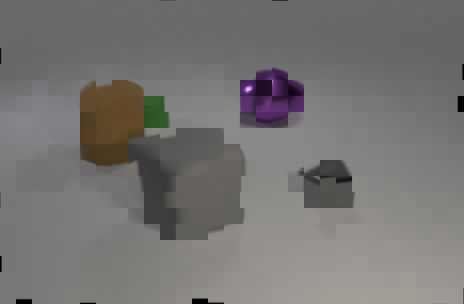

In [16]:
T.functional.to_pil_image(torchvision.utils.make_grid(xs, nrow=29, padding=0))

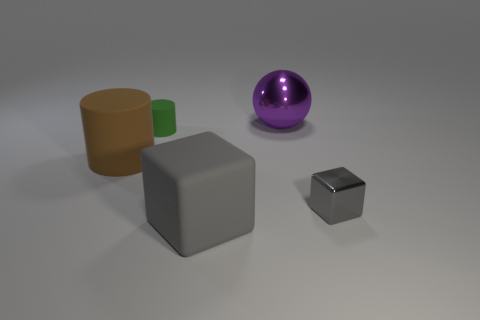

In [17]:
img

In [15]:
xs.size()

torch.Size([551, 3, 16, 16])

In [76]:
z_pres, z_pres_prob = sample_bernoulli(pres_p)

In [80]:
Z.size()[-2:]

torch.Size([29, 11])

In [86]:
# Sample z_pres
Hp, Wp = Z.size()[1:3]
ch, cw = H / Hp, W / Wp
z_pres, z_pres_prob = sample_obj_pres(pres_p)
z_depth = sample_gaussean(depth_mean, nn.functional.softplus(depth_log_std))
z_scale = sample_gaussean(scale_mean, nn.functional.softplus(scale_log_std))
z_shift = sample_gaussean(center_shift_mean, nn.functional.softplus(center_shift_log_std))

z_scale_wrt_anchor = torch.sigmoid(z_scale)
z_scale_abs = z_scale_wrt_anchor * torch.tensor(GLIMPSE_SHAPE, device=z_scale_wrt_anchor.device)
z_scale_wrt_img = z_scale_abs / torch.tensor((H, W), device=z_scale_abs.device)

z_shift_rel = torch.sigmoid(z_shift) / torch.tensor((Hp, Wp), device=z_shift.device)
ij_grid = torch.stack(torch.meshgrid((torch.arange(0, 1, 1 / Hp), torch.arange(0, 1, 1 / Wp))), dim=-1)
# z_center_wrt_rf = (ij_grid.unsqueeze(0) + z_shift_rel)
z_center_wrt_img = (ij_grid.unsqueeze(0) + z_shift_rel)
z_center_wrt_img__11 = (z_center_wrt_img * 2) - 1
# z_center_abs = z_center_wrt_rf * torch.tensor((ch, cw), device=z_shift_rel.device)
# z_center_wrt_img = z_center_abs / torch.tensor((H, W), device=z_scale_abs.device)

In [27]:
z_scale_abs = torch.ones_like(z_scale) * torch.tensor(GLIMPSE_SHAPE, device=z_scale_wrt_anchor.device)
z_scale_wrt_img = z_scale_abs / torch.tensor((H, W), device=z_scale_abs.device)

z_center_wrt_img = (ij_grid.unsqueeze(0) + torch.tensor((0.5 / Hp, 0.5 / Wp)))
z_center_wrt_img__11 = (z_center_wrt_img * 2) - 1

In [87]:
z_scale_wrt_img.size(), z_center_wrt_img__11.size()

(torch.Size([1, 19, 29, 2]), torch.Size([1, 19, 29, 2]))

In [88]:
# theta_h, theta_w = z_scale_wrt_img.transpose(1, 2).contiguous().view(-1, 2).split(1, -1)
# theta_tx, theta_ty = z_center_wrt_img__11.transpose(1, 2).contiguous().view(-1, 2).split(1, -1)

theta_h, theta_w = z_scale_wrt_img.view(-1, 2).split(1, -1)
theta_tx, theta_ty = z_center_wrt_img__11.view(-1, 2).split(1, -1)


print(theta_h.size())

_x = x.unsqueeze(1).expand(-1, Hp * Wp, -1, -1, -1)
_x = _x.view(-1, C, H, W)
_x.size()

torch.Size([551, 1])


torch.Size([551, 3, 320, 480])

In [89]:
theta = torch.cat([theta_w, torch.zeros_like(theta_w), theta_ty, torch.zeros_like(theta_w), theta_h, theta_tx], dim=-1)
# theta = theta.view(-1, 2, 3)

# theta = torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float32)
# theta = theta.view(1, 2, 3).expand(551, -1, -1)

In [90]:
_theta = theta.view(-1, 2, 3)
grid = F.affine_grid(_theta, (_theta.size(0), C, *GLIMPSE_SHAPE), align_corners=False)

In [91]:
xs = F.grid_sample(_x, grid, align_corners=False)
# xs = xs.view(Z.size(0), Hp, Wp, C, *GLIMPSE_SHAPE)
xs.size()

torch.Size([551, 3, 16, 16])

In [92]:
torchvision.utils.make_grid(xs, nrow=29, padding=0).size()

torch.Size([3, 304, 464])

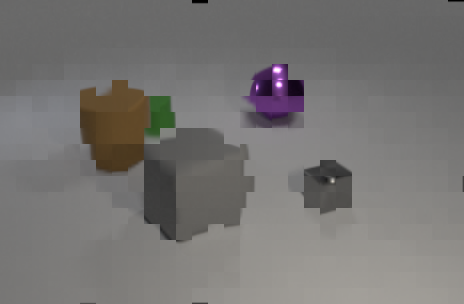

In [93]:
T.functional.to_pil_image(torchvision.utils.make_grid(xs, nrow=29, padding=0))

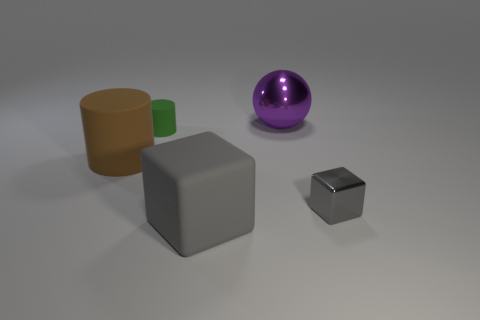

In [142]:
img

In [107]:
######### 1. SAMPLE FROM PARAMS #########
center_shift_mean, center_shift_log_std
scale_mean, scale_log_std


######### FUCNTIONS #########

# As in SPAIR's implementation
def stdize_log_std(log_std, clamp=False):
    if clamp:
        log_std = log_std.clamp(-10, 10)
    return torch.sigmoid(log_std) * 2

def stdize_and_sample(mean, log_std):
    std = stdize_log_std(log_std)
    return sample_gaussean(mean, std)

def clamped_sigmoid(logit, use_analytical=False):
    '''
    Sigmoid function,
    :param logit:
    :param use_analytical: use analytical sigmoid function to prevent backprop issues in pytorch
    :return:
    '''
    if use_analytical:
        return 1 / ((-logit).exp() + 1)

    return torch.sigmoid(torch.clamp(logit, -10, 10))


######### 2. COMPUTE RELATIVE BOXES #########
# (H, W) : Original height and width
H, W = (320, 480)
# (H', W') : Encoded image height and width
Hp, Wp = Z.size()[1:3]
# (ch, cw) : Hp = ceil(H / ch), Wp = ceil(W / cw). aproximation
ch, cw = int(H // Hp), int(W // Wp)

# Sample center and scale logits
center_shift_logits = stdize_and_sample(center_shift_mean, center_shift_log_std) # (BSZ, H', W', (y, x))
scale_logits = stdize_and_sample(scale_mean, scale_log_std) # (BSZ, H', W', (y, x))

## Compute center shift
# un-logitize
center_shift = clamped_sigmoid(center_shift_logits)
# compute shift wrt (ch, cw)
# yx ~ [-0.5 , 1.5] this prevents the center from being outside of the cell (?)
center_shift = float(MAX_YX - MIN_YX) * center_shift + MIN_YX
# build (i,j) meshgrid
ij_grid = torch.stack(torch.meshgrid([torch.arange(0, Hp), torch.arange(0, Wp)]), dim=-1)
ij_grid = ij_grid.to(device=center_shift.device).unsqueeze(0) # (1, H', W', (y, x)) 
# Compute absolute centers
center_abs = (center_shift + ij_grid) * torch.tensor((ch, cw), dtype=torch.float32, device=center_shift.device)
# Compute center WRT ANCHORBOXES
center_anchors = center_abs / torch.tensor(ANCHORBOX_SHAPE, dtype=torch.float32, device=center_shift.device)

## Compute bounding box height and width
# un-logitize
scale = clamped_sigmoid(scale_logits)
# Make sure scale is in predefined range
# --- height/width transform ---
# hw ~ [0.0 , 1.0]
scale = (MAX_HW - MIN_HW) * scale + MIN_HW
# Scale is assumed to be wrt ANCHOANCHORBOX_SHAPE

bboxes_wrt_anchors = torch.cat([center_anchors, scale], dim=-1)

In [158]:
bboxes_wrt_anchors

tensor([[[[ 0.3217,  0.3792,  0.4435,  0.2542],
          [ 0.2454,  0.3137,  0.6656,  0.4932],
          [ 0.2593,  0.8409,  0.8614,  0.6771],
          ...,
          [ 0.1271,  8.8391,  0.1795,  0.4515],
          [ 0.3030,  9.1770,  0.5501,  0.2966],
          [ 0.2693,  9.5492,  0.6605,  0.3243]],

         [[ 0.6292, -0.0447,  0.2854,  0.2876],
          [ 0.3283,  0.6489,  0.0880,  0.6371],
          [ 0.3908,  1.1152,  0.1686,  0.1978],
          ...,
          [ 0.5350,  8.9721,  0.8512,  0.6628],
          [ 0.4865,  8.9159,  0.4810,  0.3318],
          [ 0.5094,  9.7075,  0.4341,  0.3913]],

         [[ 0.6521,  0.0485,  0.3399,  0.5139],
          [ 0.8719,  0.4440,  0.3446,  0.7199],
          [ 0.7265,  1.0095,  0.7081,  0.3941],
          ...,
          [ 0.7527,  8.6833,  0.6143,  0.5293],
          [ 0.7918,  9.0181,  0.3260,  0.2576],
          [ 0.7166,  9.4020,  0.4401,  0.2465]],

         ...,

         [[ 5.3923,  0.1599,  0.5756,  0.7731],
          [ 5.7555,  0

# Spatial Transformer

In [60]:
import torch.nn.functional as F
from torch.utils import data
from PIL import Image

In [38]:
img = Image.open('/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/images/val/CLEVR_val_000000.png')
img = img.convert('RGB')
x = np.array(img)
tensor_x = torch.Tensor(x)
my_dataset = data.TensorDataset(transforms.functional.to_tensor(np.array(img))[None])

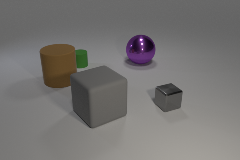

In [92]:
IMG_SIZE = (3, 160, 240)
_img = img.resize(IMG_SIZE[-1:0:-1])
x = torchvision.transforms.functional.to_tensor(_img).unsqueeze(0)
_img

theta
tensor([[[1.0000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000]]])
grid size
torch.Size([1, 80, 120, 2])


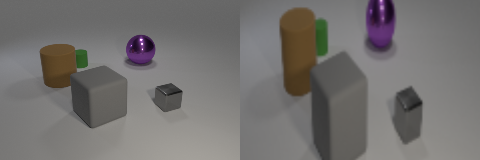

In [216]:
h, w = 0.5, 1
tx, ty = 0, 0
theta = torch.tensor([w, 0, tx, 0, h, tw], dtype=torch.float32)
theta = theta.view(1, 2, 3)
print('theta')
print(theta)
grid = F.affine_grid(theta, (1, 3, 80, 120), align_corners=True)
print('grid size')
print(grid.size())
_xs = F.grid_sample(x, grid, align_corners=True)
_xs_upsampled = F.interpolate(_xs, size=x.size()[2:], align_corners=True, mode='bilinear')
cat_images = torch.cat((x[0],_xs_upsampled[0]), dim=-1)
torchvision.transforms.functional.to_pil_image(cat_images)

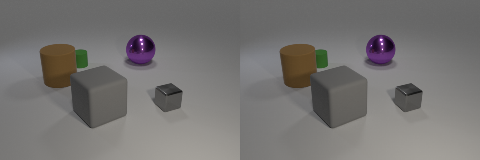

In [104]:
torchvision.transforms.functional.to_pil_image(torch.cat((x[0],_xs[0]), dim=-1))

In [25]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

NameError: name 'img' is not defined

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [29]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [30]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

In [31]:
for epoch in range(1, 20 + 1):
    train(epoch)
    test()

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313059


KeyboardInterrupt: 